Link do zródła - https://keras.io/examples/generative/neural_style_transfer/

Transfer stylu polega na generowaniu obrazu z taką samą "zawartością" jak obraz podstawowy, ale z "stylem" innego obrazu (zazwyczaj artystycznego). Osiąga się to poprzez optymalizację funkcji straty, która ma 3 składniki: "style loss", "content loss", and "total variation loss"

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import vgg19

base_image_path = keras.utils.get_file('Brooklyn_Bridge.jpg', 'https://rzucijedz.pl/images/2019/11/20/brooklyn-bridge-ciekawostki-min_large.jpg')
style_reference_image_path = keras.utils.get_file('BBstyle.jpg', 'https://ipicasso.pl/image/cache/data/goods/00000005422-800x800.jpg')

# result_prefix = 'Brooklyn_Bridge_generated'
result_prefix = 'layertest_gen'  ##zmiana warstw

# Weights of the different loss components
total_variation_weight = 1e-6
style_weight = 2e-6
content_weight = 2e-8

# Dimensions of the generated picture.
width, height = keras.preprocessing.image.load_img(base_image_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)

Wyświetlenie obrazu bazowego oraz obrazu stylu

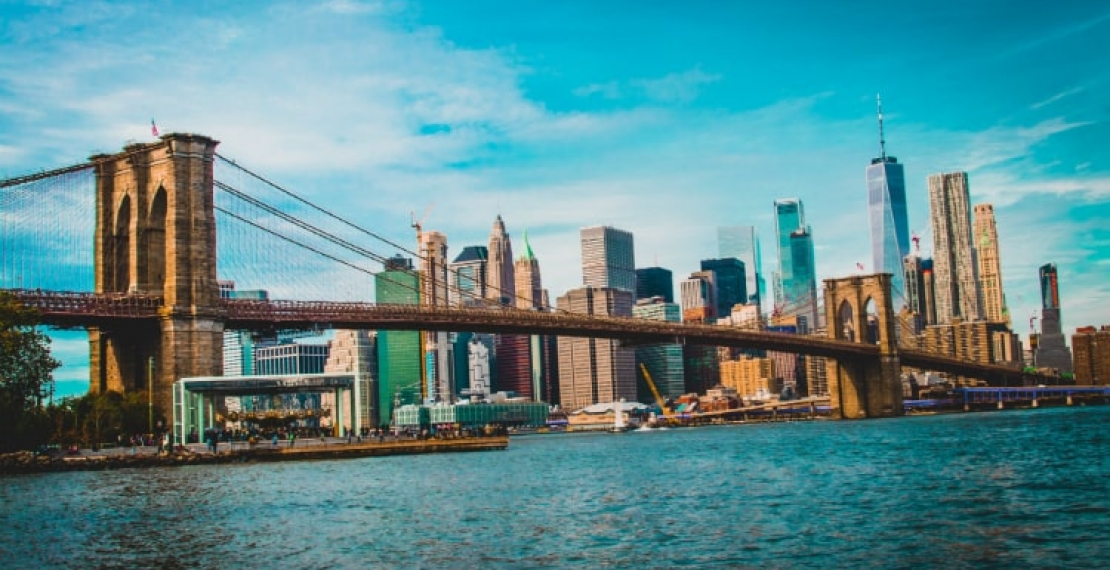

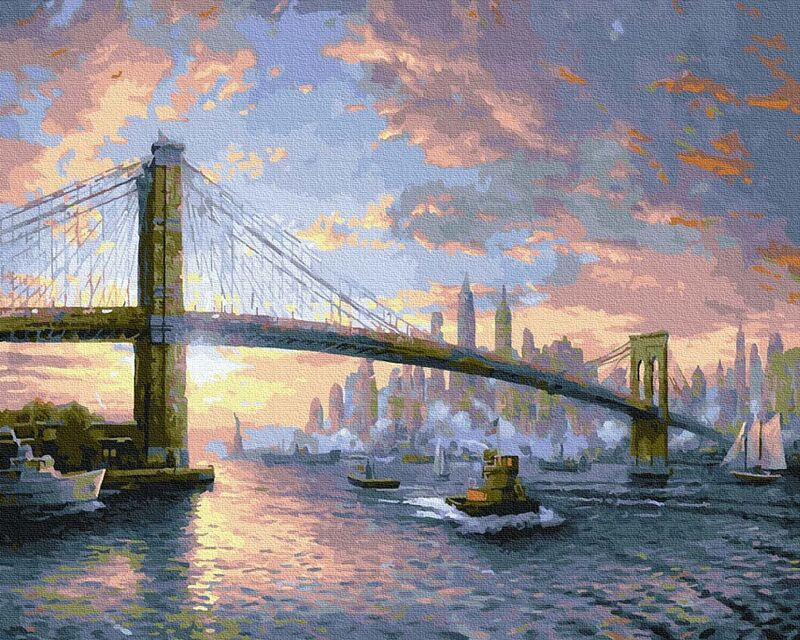

In [ ]:
from IPython.display import Image, display
display(Image(base_image_path))
display(Image(style_reference_image_path))

Narzędzia przetwarzania  obrazu

In [ ]:
def preprocess_image(image_path):
  # Util function to open, resize and format pictures into appropriate tensors
  img = keras.preprocessing.image.load_img(image_path, target_size=(img_nrows, img_ncols))
  img = keras.preprocessing.image.img_to_array(img)
  img = np.expand_dims(img, axis=0)
  img = vgg19.preprocess_input(img)
  return tf.convert_to_tensor(img)

def deprocess_image(x):
  # Util function to convert a tensor into a valid image
  x = x.reshape((img_nrows, img_ncols, 3))
  # Remove zero-center by mean pixel
  x[:, :, 0] += 103.939
  x[:, :, 1] += 116.779
  x[:, :, 2] += 123.68
  # 'BGR'->'RGB'
  x = x[:, :, ::-1]
  x = np.clip(x, 0, 255).astype('uint8')
  return x

**Obliczanie utraty transferu stylu**

Najpierw musimy zdefiniować 4 funkcje użytkowe:

>gram_matrix (służy do obliczania utraty stylu)

>Funkcja style_loss, która utrzymuje wygenerowany obraz blisko lokalnych tekstur obrazu stylu

>Funkcja content_loss, która utrzymuje reprezentację wysokiego poziomu wygenerowanego obrazu blisko tej obrazu bazowego

>Funkcja total_variation_loss, która utrzymuje generowany obraz lokalnie spójny

In [ ]:
# The gram matrix of an image tensor (feature-wise outer product)

def gram_matrix(x):
  x = tf.transpose(x, (2, 0, 1))
  features = tf.reshape(x, (tf.shape(x)[0], -1))
  gram = tf.matmul(features, tf.transpose(features))
  return gram

# The "style loss" is designed to maintain
# the style of the reference image in the generated image.
# It is based on the gram matrices (which capture style) of
# feature maps from the style reference image
# and from the generated image

def style_loss(style, combination):
  S = gram_matrix(style)
  C = gram_matrix(combination)
  channels = 3
  size = img_nrows * img_ncols
  return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))

# An auxiliary loss function
# designed to maintain the "content" of the
# base image in the generated image

def content_loss(base, combination):
  return tf.reduce_sum(tf.square(combination - base))

# The 3rd loss function, total variation loss,
# designed to keep the generated image locally coherent

def total_variation_loss(x):
  a = tf.square(
      x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, 1:, :img_ncols - 1, :])
  b = tf.square(
      x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, :img_nrows - 1, 1:, :])
  return tf.reduce_sum(tf.pow(a + b, 1.25))

Następnie utwórzmy model wyodrębniania funkcji, który pobiera pośrednie aktywacje VGG19 (jako dict, według nazwy).

In [ ]:
# Build a VGG19 model loaded with pre-trained ImageNet weights
# model = vgg19.VGG19(weights='imagenet', include_top=False)

basemodel = vgg19.VGG19(include_top = False, weights='imagenet')    ##zmiana warstw, pierwsze 10 z VGG19
model = tf.keras.Sequential(basemodel.layers[:10])
model.add(keras.layers.Conv2D(32, (7, 7), activation = 'relu'))
model.summary()

# Get the symbolic outputs of each "key" layer (we gave them unique names).
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

# Set up a model that returns the activation values for every layer in
# VGG19 (as a dict).
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, None, None, 256)  

Na koniec oto kod, który oblicza utratę transferu stylu.

In [ ]:
# List of layers to use for the style loss.

# style_layer_names = [
#   'block1_conv1', 'block2_conv1',
#   'block3_conv1', 'block4_conv1',
#   'block5_conv1'
# ]

style_layer_names = [  ##zmiana warstw         
  'block1_conv1', 'block2_conv1',
  'block3_conv1', 'conv2d_2',
]

# The layer to use for the content loss.

# content_layer_name = 'block5_conv2'
content_layer_name = 'block3_conv2'  ##zmiana warstw


def compute_loss(combination_image, base_image, style_reference_image):
  input_tensor = tf.concat([base_image,
                            style_reference_image,
                            combination_image], axis=0)
  features = feature_extractor(input_tensor)

  # Initialize the loss
  loss = tf.zeros(shape=())

  # Add content loss
  layer_features = features[content_layer_name]
  base_image_features = layer_features[0, :, :, :]
  combination_features = layer_features[2, :, :, :]
  loss = loss + content_weight * content_loss(base_image_features,
                                              combination_features)
  # Add style loss
  for layer_name in style_layer_names:
    layer_features = features[layer_name]
    style_reference_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_reference_features, combination_features)
    loss += (style_weight / len(style_layer_names)) * sl
  
  # Add total variation loss
  loss += total_variation_weight * total_variation_loss(combination_image)
  return loss

In [ ]:
# poprawny
model.summary()
#feature_extractor.summary()

Dekorator tf.function do obliczeń strat i gradientu

In [ ]:
@tf.function
def compute_loss_and_grads(combination_image, base_image, style_reference_image):
  with tf.GradientTape() as tape:
    loss = compute_loss(combination_image, base_image, style_reference_image)
  grads = tape.gradient(loss, combination_image)
  return loss, grads

**Pętla treningowa**

Wielokrotnie uruchamia kroki zejścia gradientu walidacyjnego, aby zminimalizować straty, i zapisuj wynikowy obraz co 100 iteracji.

Zmniejszamy wskaźnik uczenia się o 0,96 co 100 kroków.

In [ ]:
optimizer = keras.optimizers.SGD(
    keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=100.,
                                                decay_steps=100,
                                                decay_rate=0.96)
)

base_image = preprocess_image(base_image_path)
style_reference_image = preprocess_image(style_reference_image_path)
combination_image = tf.Variable(preprocess_image(base_image_path))

iterations = 5000

for i in range(iterations):
  loss, grads = compute_loss_and_grads(combination_image, base_image, style_reference_image)
  optimizer.apply_gradients([(grads, combination_image)])
  if i % 100 == 0:
    print('Iteration %d: loss=%.2f' % (i, loss))
    img = deprocess_image(combination_image.numpy())
    fname = result_prefix + '_at_iteration_%d.png' % i
    keras.preprocessing.image.save_img(fname, img)

Iteration 0: loss=5446.73
Iteration 100: loss=4034.85
Iteration 200: loss=3637.03
Iteration 300: loss=3430.32
Iteration 400: loss=3294.93
Iteration 500: loss=3196.20
Iteration 600: loss=3119.69
Iteration 700: loss=3057.95
Iteration 800: loss=3006.92
Iteration 900: loss=2963.99
Iteration 1000: loss=2927.35
Iteration 1100: loss=2895.72
Iteration 1200: loss=2868.15
Iteration 1300: loss=2843.89
Iteration 1400: loss=2822.38
Iteration 1500: loss=2803.20
Iteration 1600: loss=2786.02
Iteration 1700: loss=2770.52
Iteration 1800: loss=2756.48
Iteration 1900: loss=2743.75
Iteration 2000: loss=2732.15
Iteration 2100: loss=2721.54
Iteration 2200: loss=2711.82
Iteration 2300: loss=2702.88
Iteration 2400: loss=2694.63
Iteration 2500: loss=2687.02
Iteration 2600: loss=2679.97
Iteration 2700: loss=2673.42
Iteration 2800: loss=2667.34
Iteration 2900: loss=2661.68
Iteration 3000: loss=2656.40
Iteration 3100: loss=2651.48
Iteration 3200: loss=2646.87
Iteration 3300: loss=2642.56
Iteration 3400: loss=2638.

Po 5000 iteracji otrzymujemy następujący wynik:

Wynikowy obraz z użyciem pierwszych 10 warstw sieci VGG-19

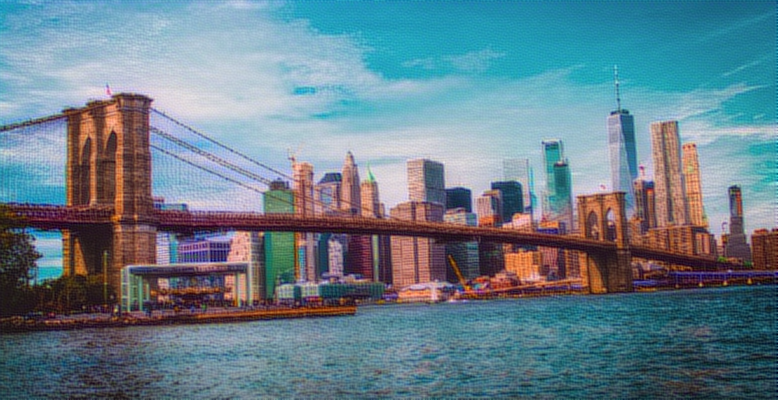

In [ ]:
display(Image(fname))